# Background knowledge

I think these videos is worth your time
- https://www.youtube.com/watch?v=orDKvo8h71o
- https://www.youtube.com/watch?v=l8pRSuU81PU

I haven't watched these videos
- https://www.youtube.com/watch?v=kCc8FmEb1nY

# Loading the model

In [1]:
# from https://huggingface.co/Qwen/Qwen2.5-0.5B-Instruct
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/Users/htong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [3]:
print(response)

Certainly! A large language model (LLM) is an artificial intelligence system that can generate human-like text based on the input it receives. These models are designed to be extremely powerful and flexible, capable of understanding natural language inputs and generating coherent responses.

The term "large" in LLM refers to the scale at which these models operate. They often use deep learning architectures like Transformers or GPT-3, which have been trained on vast amounts of data to achieve high levels of performance. These models are particularly effective for tasks such as translation, summarization, question answering, and more complex language generation.

LLMs are widely used in various applications across different industries, including but not limited to:

1. **Chatbots**: Many businesses and online services rely on chatbots powered by LLMs to provide customer support and automate routine interactions.
2. **NLP**: In fields like machine translation, text classification, and in

In [4]:
tokenizer.vocab_size

151643

In [5]:
tokenizer.eos_token_id

151645

In [6]:
model.vocab_size  # this includes the special tokens

151936

In [7]:
tokenizer.eos_token

'<|im_end|>'

In [8]:
model.num_parameters()

494032768

# Architecture

In [9]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [10]:
model.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-0.5B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.47.1",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

In [11]:
model.device

device(type='mps', index=0)

# Parameter counting

In [12]:
def count_parameters(module):
    return sum(p.numel() for p in module.parameters())

In [13]:
count_parameters(model), model.model.num_parameters()

(494032768, 494032768)

In [14]:
model.model.norm, count_parameters(model.model.norm)

(Qwen2RMSNorm((896,), eps=1e-06), 896)

In [15]:
model.model.rotary_emb, count_parameters(model.model.rotary_emb)

(Qwen2RotaryEmbedding(), 0)

In [16]:
(model.model.layers[0].self_attn.q_proj, count_parameters(model.model.layers[0].self_attn.q_proj))

(Linear(in_features=896, out_features=896, bias=True), 803712)

In [17]:
(model.model.layers[0].self_attn.o_proj, count_parameters(model.model.layers[0].self_attn.o_proj))

(Linear(in_features=896, out_features=896, bias=False), 802816)

# Transformer module

In [18]:
# notice that the dimension of k_proj and v_proj is different from q_proj
model.model.layers[0]

Qwen2DecoderLayer(
  (self_attn): Qwen2SdpaAttention(
    (q_proj): Linear(in_features=896, out_features=896, bias=True)
    (k_proj): Linear(in_features=896, out_features=128, bias=True)
    (v_proj): Linear(in_features=896, out_features=128, bias=True)
    (o_proj): Linear(in_features=896, out_features=896, bias=False)
    (rotary_emb): Qwen2RotaryEmbedding()
  )
  (mlp): Qwen2MLP(
    (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
    (up_proj): Linear(in_features=896, out_features=4864, bias=False)
    (down_proj): Linear(in_features=4864, out_features=896, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
  (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
)

In [19]:
type(model.model.layers[0])

transformers.models.qwen2.modeling_qwen2.Qwen2DecoderLayer

In [20]:
count_parameters(model.model.layers[0])

14912384

In [21]:
import inspect
import transformers
print(inspect.getsource(transformers.models.qwen2.modeling_qwen2.Qwen2DecoderLayer.forward))

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # will become mandatory in v4.46
        **kwargs,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`, *optional*): attention mask of size
                `(batch, sequence_length)` where padding elements are indicated by 0.
            output_attentions (`bool`, *optional*):
                Whether or

# Attention layer

In [22]:
model.model.layers[0].self_attn

Qwen2SdpaAttention(
  (q_proj): Linear(in_features=896, out_features=896, bias=True)
  (k_proj): Linear(in_features=896, out_features=128, bias=True)
  (v_proj): Linear(in_features=896, out_features=128, bias=True)
  (o_proj): Linear(in_features=896, out_features=896, bias=False)
  (rotary_emb): Qwen2RotaryEmbedding()
)

In [23]:
type(model.model.layers[0].self_attn)

transformers.models.qwen2.modeling_qwen2.Qwen2SdpaAttention

In [24]:
count_parameters(model.model.layers[0].self_attn)

1836160

In [25]:
count_parameters(model.model.layers[0].mlp)  # has more parameters

13074432

In [26]:
model.model.layers[0].self_attn.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-0.5B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.47.1",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

In [27]:
import inspect
import transformers
print(inspect.getsource(transformers.models.qwen2.modeling_qwen2.Qwen2SdpaAttention.__init__))

    def __init__(self, config: Qwen2Config, layer_idx: Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        if layer_idx is None:
            logger.warning_once(
                f"Instantiating {self.__class__.__name__} without passing `layer_idx` is not recommended and will "
                "to errors during the forward call, if caching is used. Please make sure to provide a `layer_idx` "
                "when creating this class."
            )

        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_position_embeddings
        self.rope_theta = config.rope_theta
        self.is_causal = True
        self.attention_dropout = co

In [28]:
import inspect
import transformers
print(inspect.getsource(transformers.models.qwen2.modeling_qwen2.Qwen2SdpaAttention.forward))

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # will become mandatory in v4.46
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        if output_attentions:
            # TODO: Improve this warning with e.g. `model.config.attn_implementation = "manual"` once this is implemented.
            logger.warning_once(
                "Qwen2Model is using Qwen2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, "
                'but specifying the manual 

In [29]:
# Qwen2SdpaAttention.forward is a wrapper around scaled_dot_product_attention
# applying positional embedding
# added caching logic (not sure if optimal)
# multi‐query attention - which involves key state and value state copying

In [30]:
import torch
torch.nn.functional.scaled_dot_product_attention
# https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html

<function torch._C._nn.scaled_dot_product_attention>

In [31]:
# Efficient implementation equivalent to the following (o1 rewritten):
from typing import Optional
def scaled_dot_product_attention(
    query: torch.Tensor,   # shape [..., Q_seq_len, embedding_dim]
    key: torch.Tensor,     # shape [..., K_seq_len, embedding_dim]
    value: torch.Tensor,   # shape [..., K_seq_len, embedding_dim]
    attn_mask: Optional[torch.Tensor] = None,
    dropout_p: float = 0.0,
    is_causal: bool = False,
    scale: Optional[float] = None,
    enable_gqa: bool = False
) -> torch.Tensor:
    # Extract lengths and embedding dimension
    Q_seq_len, K_seq_len = query.size(-2), key.size(-2)
    embedding_dim = query.size(-1)

    # If scale is None, default is 1 / sqrt(embedding_dim)
    scale_factor = 1 / math.sqrt(embedding_dim) if scale is None else scale

    # attn_bias: shape [Q_seq_len, K_seq_len]
    attn_bias = torch.zeros(Q_seq_len, K_seq_len, dtype=query.dtype)

    # If causal masking is enabled, create a lower-triangular mask
    if is_causal:
        assert attn_mask is None, "Cannot combine attn_mask with is_causal."
        # temp_mask: shape [Q_seq_len, K_seq_len], bool
        temp_mask = torch.ones(Q_seq_len, K_seq_len, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    # If attn_mask is provided
    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            # For boolean masks, set invalid positions to -inf
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            # For floating masks, add them directly (e.g., additive mask)
            attn_bias += attn_mask

    # If grouped-query attention is enabled, repeat key/value to match query shape
    if enable_gqa:
        # key and value might be repeated along their "batch-like" axis
        key = key.repeat_interleave(query.size(-3) // key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3) // value.size(-3), -3)

    # Compute raw attention scores:
    # [Q_seq_len, embedding_dim] @ [embedding_dim, K_seq_len] -> [Q_seq_len, K_seq_len]
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias

    # Normalize along the last dimension (K_seq_len)
    attn_weight = torch.softmax(attn_weight, dim=-1)

    # Apply dropout on attention weights
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)

    # Output: [Q_seq_len, K_seq_len] @ [K_seq_len, embedding_dim] -> [Q_seq_len, embedding_dim]
    return attn_weight @ value

# Diagram

![](architecture.drawio.svg)


- White is needed for working memory.
- Yellow is what could be cached.
- Red is what needs to be computed for every new token generated.

# Multi-query attention

```
self.head_dim = self.hidden_size // self.num_heads
self.num_key_value_groups = self.num_heads // self.num_key_value_heads
```

In [32]:
# input configs
(
    model.model.layers[0].self_attn.hidden_size,
    model.model.layers[0].self_attn.num_heads,
    model.model.layers[0].self_attn.num_key_value_heads,
)

(896, 14, 2)

In [33]:
# derived configs
(
    model.model.layers[0].self_attn.head_dim,
    model.model.layers[0].self_attn.num_key_value_groups,
)

(64, 7)

The purpose of multi-query attention

- Reap the benefits of multi-head attention but limit number of the key-value embeddings to cache

# Complexity

Complexity of to generate the first token - just the attention mechanism

The query length is the sequence length

```
- Time   O(sequence_length^2 * num_layers * embedding_dim)
  parallelizable to O(num_layers * (log(sequence_length) + log(embedding_dim)))
- Memory O(sequence_length^2 * num_layers * embedding_dim) if parallelizing
- Cache  O(sequence_length   * num_layers * head_dim * num_key_value_groups)
```

Complexity of autoregressive decoding per token - just the attention mechanism

The query length is just one

```
- Time   O(sequence_length * num_layers * embedding_dim)
  parallelizable to O(num_layers * (log(sequence_length) + log(embedding_dim)))
- Memory O(sequence_length * num_layers * embedding_dim) if parallelizing
- Cache  O(num_layers * head_dim * num_key_value_groups)
```

# Positional embeddings

In [34]:
embeddings = torch.ones(1).to(model.device)
position_ids = torch.arange(50).unsqueeze(0).to(model.device)

In [35]:
sin, cos = model.model.layers[0].self_attn.rotary_emb(embeddings, position_ids)

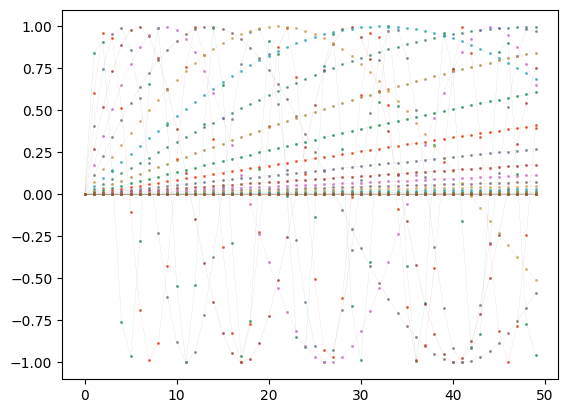

In [36]:
import matplotlib.pyplot as plt
plt.plot(cos.cpu()[0], 'o-', ms=1, lw=0.05, alpha=0.5)  # Increase marker size
plt.show()

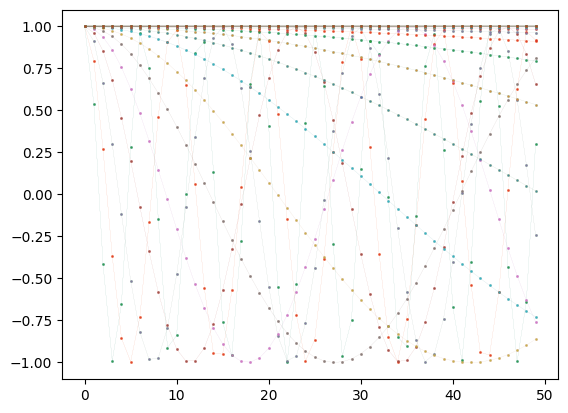

In [37]:
import matplotlib.pyplot as plt
plt.plot(sin.cpu()[0], 'o-', ms=1, lw=0.05, alpha=0.5)  # Increase marker size
plt.show()

- The first pair of values in the embedding is rotated by 1 $\times$ position_id / 100_000
- The second pair of values in the embedding is rotated by 2 $\times$ position_id / 100_000
- ... etc

# Observations

- For a certain value in the output of the attention mechanism, can you trace the calculations?
- The key value embeddings is cached (you don't need to store past query embeddings)
- The embedding size before and after each attention layer
- Where the residual connections are
- Positional embeddings is applied on the key value embeddings `apply_rotary_pos_emb`
- The architecture is heavily parallelizable
- The complexity increases quadratically over sequence length
- The number of parameters is invariant to sequence length (as positional embeddings are sinosoids)

# Think of how these works

- [Prompt caching](https://platform.openai.com/docs/guides/prompt-caching)
- [Predicted outputs](https://platform.openai.com/docs/guides/predicted-outputs)
- [Speculative decoding](https://docs.vllm.ai/en/latest/usage/spec_decode.html)

# Other readings

- [Flash attention](https://arxiv.org/pdf/2205.14135)